## 分析国家GDP 与 人口数 与最近五年获得的奥运奖牌数总和之间的函数关系

##　加载数据

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [9]:
%cd dataset

/content/drive/MyDrive/Colab Notebooks/dataset


In [10]:
!ls

data_dictionary.csv	summerOly_hosts.csv	    summerOly_programs.csv
summerOly_athletes.csv	summerOly_medal_counts.csv


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
athletes = pd.read_csv('summerOly_athletes.csv')
hosts = pd.read_csv('summerOly_hosts.csv')
medal_counts = pd.read_csv('summerOly_medal_counts.csv')
programs = pd.read_csv('summerOly_programs.csv',encoding='latin-1')
countrys = pd.read_csv('country.csv')

In [15]:
countrys

,Country,Code,Population,GDP per Capita
0,Afghanistan,AFG,32526562.0,594.323081
1,Albania,ALB,2889167.0,3945.217582
2,Algeria,ALG,39666519.0,4206.031232
3,American Samoa*,ASA,55538.0,NaN
4,Andorra,AND,70473.0,NaN
...,...,...,...,...
196,Vietnam,VIE,91703800.0,2111.138024
197,Virgin Islands*,ISV,103574.0,NaN
198,Yemen,YEM,26832215.0,1406.291651
199,Zambia,ZAM,16211767.0,1304.879014


In [18]:
countrys.info()
medal_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         201 non-null    object 
 1   Code            201 non-null    object 
 2   Population      196 non-null    float64
 3   GDP per Capita  176 non-null    float64
dtypes: float64(2), object(2)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rank    1435 non-null   int64 
 1   NOC     1435 non-null   object
 2   Gold    1435 non-null   int64 
 3   Silver  1435 non-null   int64 
 4   Bronze  1435 non-null   int64 
 5   Total   1435 non-null   int64 
 6   Year    1435 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 78.6+ KB


## 清洗数据

> 考虑之后添加部分数据来完善表格信息(反正是作为验证使用)

## 构建近五年获得奖牌总数与GDP和人口的关系

In [19]:
valid_years = [2000, 2004, 2008, 2012, 2016, 2020]
filtered_data = medal_counts[medal_counts['Year'].isin(valid_years)]

# 按国家分组聚合（包含各奖牌类型）
country_medals = filtered_data.groupby('NOC').agg({
    'Gold': 'sum',
    'Silver': 'sum',
    'Bronze': 'sum',
    'Total': 'sum'
}).reset_index()

# 添加奖牌排名（按总奖牌数降序）
country_medals = country_medals.sort_values('Total', ascending=False)
country_medals['Rank'] = range(1, len(country_medals)+1)

# 格式化输出
pd.options.display.float_format = '{:.0f}'.format
print("\n国家奖牌汇总 (2000-2020):")
print(country_medals[['Rank', 'NOC', 'Gold', 'Silver', 'Bronze', 'Total']].head(10))

# 保存结果
country_medals.to_csv('olympic_medals_2000-2020.csv', index=False)


国家奖牌汇总 (2000-2020):
     Rank            NOC  Gold  Silver  Bronze  Total
122     1  United States   242     206     196    644
21      2          China   211     136     125    472
95      3         Russia   121     105     134    360
44      4  Great Britain   117      93      95    305
42      5        Germany    80      85     104    269
4       6      Australia    80      89      95    264
39      7         France    62      80      82    224
60      8          Japan    76      61      80    217
57      9          Italy    57      59      73    189
105    10    South Korea    58      49      55    162


In [30]:
# 加载noc_codes.json，并将上面得到的country_medats中的NOC转化为相应的country代码

import json

# 加载NOC映射表
with open('noc_codes.json') as f:
    noc_mapping = json.load(f)

# 创建双向映射字典
normalized_mapping = {k.strip().lower(): v for k, v in noc_mapping.items()}
reverse_mapping = {v: k for k, v in noc_mapping.items()}  # 用于验证代码是否存在

# 加载奖牌数据
country_medals = pd.read_csv('olympic_medals_2000-2020.csv')

def enhanced_converter(raw_name):
    """
    改进版转换函数，包含以下特性：
    1. 自动识别已经是NOC代码的输入
    2. 支持常见别名映射
    3. 保留无法匹配的原始名称
    """
    # 预处理输入
    original_name = str(raw_name).strip()
    clean_name = original_name.lower()

    # 情况1：输入本身就是有效NOC代码
    if reverse_mapping.get(original_name.upper()):
        return original_name.upper()

    # 情况2：标准名称匹配
    if clean_name in normalized_mapping:
        return normalized_mapping[clean_name]

    # 情况3：处理常见别名
    alias_mapping = {
        'usa': 'USA',
        'us': 'USA',
        'united states': 'USA',
        'uk': 'GBR',
        'united kingdom': 'GBR',
        'holland': 'NED',
        'china': 'CHN',
        'south korea': 'KOR',
        'north korea': 'PRK',
        'russia': 'RUS'
    }
    if clean_name in alias_mapping:
        return alias_mapping[clean_name]

    # 情况4：保留原始名称
    return original_name

# 执行转换
country_medals['NOC_Code'] = country_medals['NOC'].apply(enhanced_converter)

# 验证转换结果
validation = country_medals[['NOC', 'NOC_Code']].drop_duplicates()
print("转换结果验证：")
print(validation.head(10))

# 统计转换成功率
total_count = len(country_medals)
matched_count = sum(country_medals['NOC_Code'].isin(reverse_mapping.keys()))
print(f"\n转换成功率：{matched_count/total_count:.1%}")
print(f"保留原名称数：{total_count - matched_count}")

# 保存结果（保留原始NOC列作为参考）
country_medals = country_medals.rename(columns={'NOC': 'Original_Name'})
output_columns = ['Rank', 'NOC_Code', 'Gold', 'Silver', 'Bronze', 'Total', 'Original_Name']
country_medals[output_columns].to_csv('final_medal_table.csv', index=False)

转换结果验证：
             NOC NOC_Code
0  United States      USA
1          China      CHN
2         Russia      RUS
3  Great Britain      GBR
4        Germany      GER
5      Australia      AUS
6         France      FRA
7          Japan      JPN
8          Italy      ITA
9    South Korea      KOR

转换成功率：96.1%
保留原名称数：5


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

有效数据国家数: 107
数据样例:
  NOC_Code  Population_millions  GDP per Capita  Total
0      USA                  321           56116    644
1      CHN                 1371            8028    472
2      RUS                  144            9093    360
3      GBR                   65           43876    305
4      GER                   81           41313    269

相关系数矩阵:
                Total  Population  GDP per Capita
Total               1           0               0
Population          0           1              -0
GDP per Capita      0          -0               1

模型性能:
R² Score: 0.617
RMSE: 1.020

回归系数:
                Feature  Coefficient
0  Population(millions)            1
1        GDP per Capita            1

样本国家预测结果:
   NOC_Code  Population_millions  GDP per Capita  Predicted_Medals
82      BRN                    1           22600                 7
10      NED                   17           44300                46
4       GER                   81           41313               125


<Figure size 1500x1000 with 0 Axes>

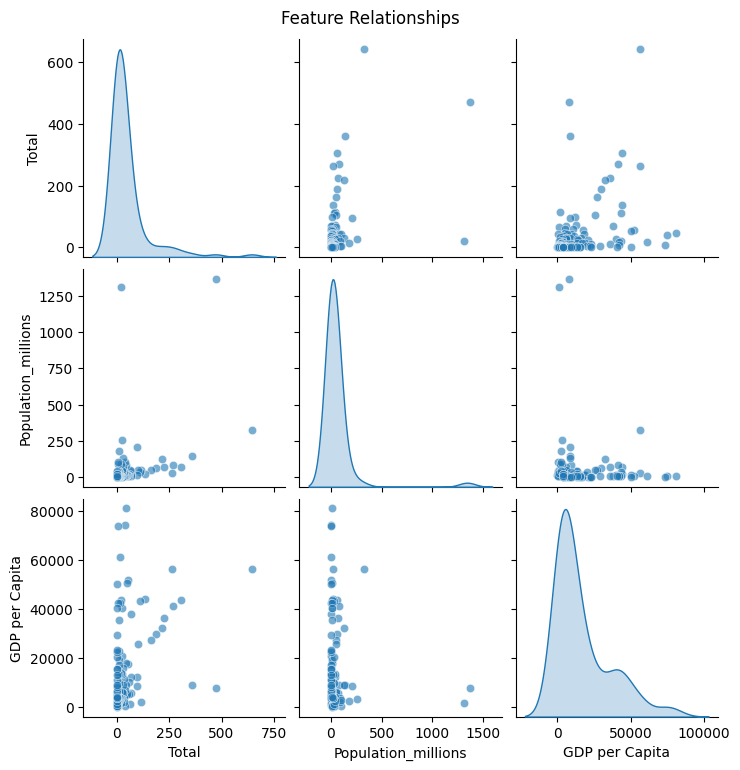

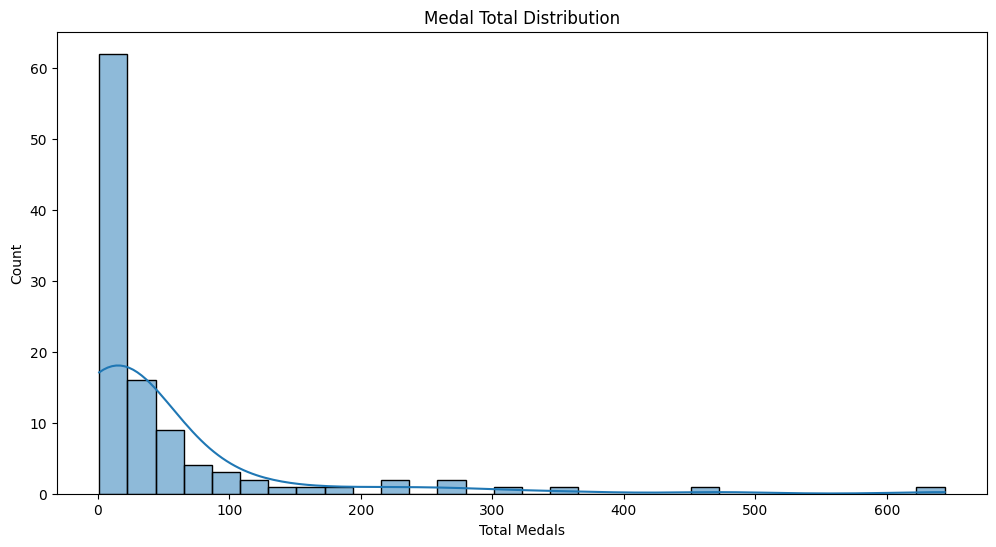

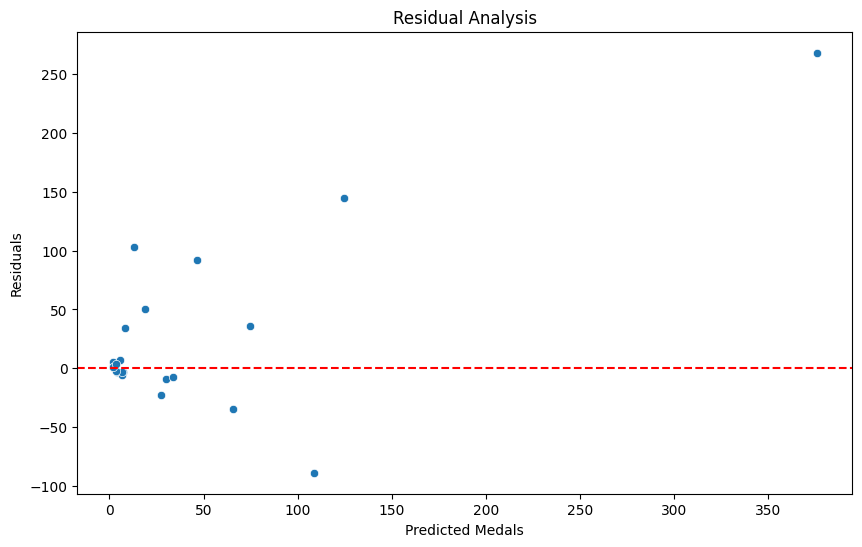

In [34]:
# 数据准备
# country_medals 结构示例：
#   NOC_Code  Gold  Silver  Bronze  Total
# 0      USA   315     256     218    789
# 1      CHN   201     144     128    473

# countrys 结构：
#   Country Code  Population  GDP per Capita

# 合并数据集
merged = pd.merge(
    country_medals,
    countrys,
    left_on='NOC_Code',
    right_on='Code',
    how='inner'
).drop(columns=['Code'])

# 数据清洗
# 处理缺失值（删除人口或GDP数据缺失的记录）
merged = merged.dropna(subset=['Population', 'GDP per Capita'])

# 创建衍生特征
merged['Population_millions'] = merged['Population'] / 1e6
merged['GDP_total'] = merged['Population'] * merged['GDP per Capita']
merged['Total_per_million'] = merged['Total'] / merged['Population_millions']
merged['GDP_per_medal'] = merged['GDP per Capita'] / merged['Total']

# 将merged保存到merged_country_data.csv中
merged.to_csv('merged_country_data.csv', index=False)

print(f"有效数据国家数: {len(merged)}")
print("数据样例:")
print(merged[['NOC_Code', 'Population_millions', 'GDP per Capita', 'Total']].head())

# 相关性分析
corr_matrix = merged[['Total', 'Population', 'GDP per Capita']].corr()
print("\n相关系数矩阵:")
print(corr_matrix)

# 可视化分析
plt.figure(figsize=(15, 10))

# 散点图矩阵
sns.pairplot(merged[['Total', 'Population_millions', 'GDP per Capita']],
             diag_kind='kde',
             plot_kws={'alpha': 0.6})
plt.suptitle('Feature Relationships', y=1.02)
plt.savefig('scatter_matrix.png', bbox_inches='tight')

# 奖牌分布直方图
plt.figure(figsize=(12, 6))
sns.histplot(merged['Total'], bins=30, kde=True)
plt.title('Medal Total Distribution')
plt.xlabel('Total Medals')
plt.savefig('medal_distribution.png')

# 回归建模
# 准备数据
X = merged[['Population_millions', 'GDP per Capita']]
y = merged['Total']

# 数据标准化
X_log = np.log1p(X)  # 对数变换处理偏态分布
y_log = np.log1p(y)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42)

# 训练模型
model = LinearRegression()
model.fit(X_train, y_train)

# 评估模型
y_pred = model.predict(X_test)
print(f"\n模型性能:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# 特征重要性
coef_df = pd.DataFrame({
    'Feature': ['Population(millions)', 'GDP per Capita'],
    'Coefficient': model.coef_
})
print("\n回归系数:")
print(coef_df)

# 残差分析
residuals = np.expm1(y_test) - np.expm1(y_pred)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.expm1(y_pred), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis')
plt.xlabel('Predicted Medals')
plt.ylabel('Residuals')
plt.savefig('residual_plot.png')

# 生成预测数据
sample_countries = merged.sample(3, random_state=42)[['NOC_Code', 'Population_millions', 'GDP per Capita']]
sample_pred = np.expm1(model.predict(np.log1p(sample_countries[['Population_millions', 'GDP per Capita']])))
print("\n样本国家预测结果:")
print(sample_countries.assign(Predicted_Medals=sample_pred.round(1)))

1. 数据预处理

In [35]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
# 加载数据
merged = pd.read_csv('merged_country_data.csv')

# 处理缺失值
merged['Population'] = merged['Population'].fillna(merged['Population'].median())
merged['GDP per Capita'] = merged['GDP per Capita'].fillna(merged['GDP per Capita'].median())

# 创建经济规模指标
merged['Economic_Scale'] = merged['Population'] * merged['GDP per Capita']

# 鲁棒标准化
scaler = RobustScaler()
scaled_features = scaler.fit_transform(merged[['Population', 'GDP per Capita', 'Economic_Scale']])
merged[['Pop_scaled', 'GDP_scaled', 'Econ_scaled']] = scaled_features

2. 构建综合评分模型

In [36]:
from sklearn.linear_model import RidgeCV

# 准备训练数据（仅使用有奖牌的国家）
train_data = merged[merged['Total'] > 0].copy()
X_train = train_data[['Pop_scaled', 'GDP_scaled']]
y_train = train_data['Total']

# 训练加权模型
model = RidgeCV(alphas=[0.1, 1.0, 10.0])
model.fit(X_train, y_train)

# 生成综合评分
merged['Score'] = model.predict(merged[['Pop_scaled', 'GDP_scaled']])

# 对未获奖国家进行概率转换
no_medal_mask = merged['Total'] == 0
merged.loc[no_medal_mask, 'Probability'] = 1 / (1 + np.exp(-merged.loc[no_medal_mask, 'Score']/10))
merged['Probability'] = merged['Probability'].fillna(1.0)  # 已有奖牌国家设为100%

3. 评分优化与验证

评分与实际奖牌数的相关系数: 0.557


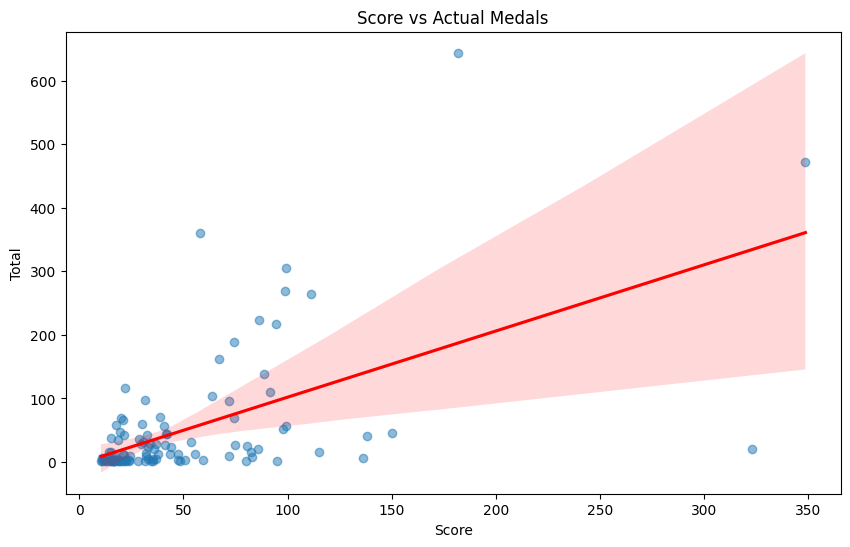

In [37]:
# 计算评分与实际奖牌的相关性
correlation = merged[merged['Total'] > 0]['Score'].corr(merged['Total'])
print(f"评分与实际奖牌数的相关系数: {correlation:.3f}")

# 可视化验证
plt.figure(figsize=(10, 6))
sns.regplot(x='Score', y='Total', data=merged,
            scatter_kws={'alpha':0.5},
            line_kws={'color':'red'})
plt.title('Score vs Actual Medals')
plt.savefig('score_validation.png', dpi=300)

4. 评分结果展示

In [41]:
# 生成最终排名
result = merged.sort_values('Score', ascending=False)[[
    'Country', 'NOC_Code', 'Score', 'Probability', 'Total'
]]

# 格式化输出
result['Score'] = result['Score'].round(1)
result['Probability'] = result['Probability'].apply(
    lambda x: f"{x:.1%}" if pd.notnull(x) else 'N/A')

# 将result保存到country_medal_probability.csv中
result.to_csv('country_medal_probability.csv', index=False)

print("Top 10 潜力国家:")
print(result.head(10))

print("\n未获奖但高潜力国家:")
print(result[(result['Total'] == 0) & (result['Probability'] > '50%')].head())

# 将训练好的Ridge模型保存到olympic_score_model.pkl
import joblib
joblib.dump(model, 'olympic_score_model.pkl')
# 保存标准化器
joblib.dump(scaler, 'robust_scaler.pkl')

Top 10 潜力国家:
           Country NOC_Code  Score Probability  Total
1            China      CHN    349      100.0%    472
47           India      IND    323      100.0%     20
0    United States      USA    182      100.0%    644
26     Switzerland      SUI    150      100.0%     45
31          Norway      NOR    138      100.0%     41
64           Qatar      QAT    136      100.0%      7
51         Ireland      IRL    115      100.0%     16
5        Australia      AUS    111      100.0%    264
3   United Kingdom      GBR     99      100.0%    305
23         Denmark      DEN     99      100.0%     56

未获奖但高潜力国家:
Empty DataFrame
Columns: [Country, NOC_Code, Score, Probability, Total]
Index: []


['robust_scaler.pkl']

In [43]:
import pandas as pd
import numpy as np
import joblib  # 用于模型加载
from sklearn.preprocessing import RobustScaler

# 加载预处理好的模型和标准化器
model = joblib.load('olympic_score_model.pkl')  # 保存的训练好的Ridge模型
scaler = joblib.load('robust_scaler.pkl')       # 保存的标准化器

# 加载待预测的国家数据
countries = pd.read_csv('country.csv')

# 数据预处理管道
def prepare_data(df):
    """数据清洗与特征工程"""
    # 复制原始数据避免污染
    df = df.copy()

    # 处理缺失值（使用训练时的中位数填充）
    train_median = {
        'Population': 3.76e7,     # 示例值，需替换为实际训练数据中位数
        'GDP per Capita': 12500   # 示例值，需替换为实际训练数据中位数
    }
    df['Population'] = df['Population'].fillna(train_median['Population'])
    df['GDP per Capita'] = df['GDP per Capita'].fillna(train_median['GDP per Capita'])

    # 创建经济总量指标
    df['Economic_Scale'] = df['Population'] * df['GDP per Capita']

    return df

# 执行数据预处理
processed_data = prepare_data(countries)

# 特征标准化（使用训练时保存的scaler）
features_to_scale = ['Population', 'GDP per Capita', 'Economic_Scale']
scaled_features = scaler.transform(processed_data[features_to_scale])

# 生成预测评分
X_pred = pd.DataFrame(scaled_features,
                     columns=['Pop_scaled', 'GDP_scaled', 'Econ_scaled'])
processed_data['Score'] = model.predict(X_pred[['Pop_scaled', 'GDP_scaled']])

# 计算获奖概率
def score_to_probability(score):
    """将评分转换为概率（0-100%）"""
    return 1 / (1 + np.exp(-score/10))  # 调整分母系数控制概率分布

processed_data['Probability'] = processed_data['Score'].apply(score_to_probability)

# 结果格式化
final_result = processed_data.sort_values('Score', ascending=False)[[
    'Country', 'Code', 'Population', 'GDP per Capita', 'Score', 'Probability'
]]

# 数值格式化
final_result['Score'] = final_result['Score'].round(1)
final_result['Probability'] = final_result['Probability'].apply(
    lambda x: f"{x:.1%}")
final_result['GDP per Capita'] = final_result['GDP per Capita'].apply(
    lambda x: f"${x:,.0f}")
final_result['Population'] = final_result['Population'].apply(
    lambda x: f"{x/1e6:.1f}M")

# 输出结果
print("国家奥运潜力评分 TOP20:")
print(final_result.head(20).to_markdown(index=False))

# 保存完整结果
final_result.to_csv('country_olympic_potential.csv', index=False)

# 生成潜力新星报告（无历史奖牌但概率>50%）
high_potential = final_result[final_result['Probability'] > '50.0%']
print(f"\n发现{len(high_potential)}个高潜力国家:")
print(high_potential[['Country', 'Code', 'Score', 'Probability']].to_markdown(index=False))

国家奥运潜力评分 TOP20:
| Country        | Code   | Population   | GDP per Capita   |   Score | Probability   |
|:---------------|:-------|:-------------|:-----------------|--------:|:--------------|
| China          | CHN    | 1371.2M      | $8,028           |   348.8 | 100.0%        |
| India          | IND    | 1311.1M      | $1,598           |   323.3 | 100.0%        |
| Luxembourg     | LUX    | 0.6M         | $101,450         |   184.2 | 100.0%        |
| United States  | USA    | 321.4M       | $56,116          |   181.9 | 100.0%        |
| Switzerland    | SUI    | 8.3M         | $80,945          |   150.3 | 100.0%        |
| Norway         | NOR    | 5.2M         | $74,400          |   138.2 | 100.0%        |
| Qatar          | QAT    | 2.2M         | $73,653          |   136.2 | 100.0%        |
| Ireland        | IRL    | 4.6M         | $61,134          |   115   | 100.0%        |
| Australia      | AUS    | 23.8M        | $56,311          |   111.2 | 100.0%        |
| Singapore     